# 变换三维对象


一般情况下, 变换即以一个向量为输入, 计算后的向量为输出, 类似如下代码

```python
def transform(v: Vector) -> Vector:
    x, y, z = v
    # 进行计算
    return (new_x, new_y, new_z)
```


## 1. 绘制变换后的对象


### 1.1. 绘制原始模型


**练习:** 读取模型文件

模型文件由三部分组成: 
- 整体信息: 包括第一行的 `OFF` 标记和第二行的 `480  448  926`, 表示每部分数据的行数
- 向量信息: 除头两行外, 前 `480` 行数据表示三维向量
- 多面体信息: 除头两行外, 从 `480` 行到 `480 + 448 = 928` 行为平面定义数据, 每组为 `5` 个数字, 后 `4` 个表示前 `480` 行向量的行号, `4` 个向量组成两个三角形

尝试读取 `4 439 438 8 9` 对应的数据

In [1]:
from typing import Iterable, Sequence

from utils.typedef import Triangle, Vector3D


def triangulate(vs: Sequence[Vector3D]) -> Iterable[Triangle]:
    """将一个三维向量序列转为三角形序列集合

    参数为一个三维向量序列, 可包括 N 个向量, 返回 M 个三角形, `vs` 参数包括最少 3 个向量, 否则无法组成三角形

    ```
            * (0)
    * (1)
                * (2)
            * (3)
    ```

    Args:
        `vs` (`Sequence[Vector3D]`): 一组由四个三维向量组成的集合

    Yields:
        `Iterable[Triangle]`: 返回一个生成器, 产生相关的两个三角形向量集合
    """
    # 将四个向量坐标拆分成两个三角形

    # 连接 0-2-1 和 0-3-2, 将一个四边形分为两个三角形
    for i in range(1, len(vs) - 1):
        yield (vs[0], vs[i + 1], vs[i])

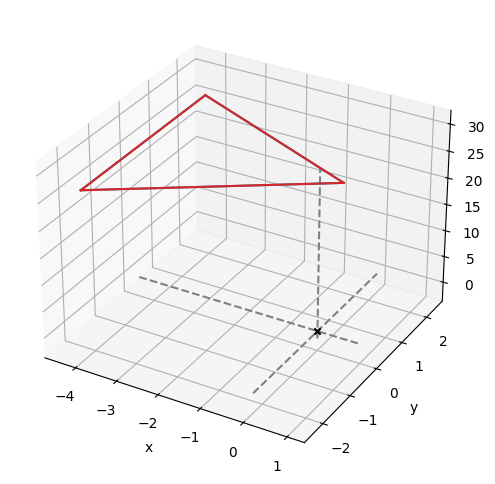

In [2]:
from utils.transform import triangulate
from utils.vector import as_triangle, scale
from utils.draw.component import Color, Polygon3D, draw3d

# 读取的 4 439 438 8 9 这行数据对应的四个向量
vs = [
    (-0.0827332, -0.0421881, 0.529498),
    (-0.0827332, 0.0421881, 0.529498),
    (0.0107422, 0, 0.575333),
    (0.0125, 0.0562508, 0.450561),
]

# 向量放大 50 倍
vs = as_triangle(scale(50.0, v) for v in vs)

# 将四个三维向量计算为两个三角形面
polygons = [Polygon3D(t, color=Color.blue()) for t in triangulate(vs)]

# 绘制
draw3d(
    [
        *polygons,  # 绘制四个向量拆分的两个三角形
        Polygon3D(vs, color=Color.red()),  # 绘制四个向量组成的图形
    ]
)

**练习:** 绘制原始模型


In [3]:
%%capture

!python ./play/draw_teapot.py

### 1.2. 将原始模型放大 2 倍


**知识:** 通过 [`scale` 函数](./vectors.py), 通过放大向量长度, 进一步可以将向量组成的三角形放大

整个操作相当于将输入向量置于多个"处理器", 每个处理器的输出是下一个处理器的输入

![X](../assets/transform1.jpg)

将这些处理器连接起来后, 即可对输入向量进行各种处理

![X](../assets/transform2.jpg)


**练习:** 绘制放大 `2` 倍后的模型


In [4]:
%%capture

!python ./play/scale_teapot.py

### 1.3. 绕固定坐标轴旋转向量


**知识:** 旋转二维向量

对于二维向量, 改变其角度的方法为: 将笛卡儿坐标转换为极坐标, 按旋转系数增加或减少角度, 然后再转换回来


In [5]:
from utils.typedef import Vector2D
from utils.vector import to_cartesian, to_polar


def rotate2d(angle: float, v: Vector2D) -> Vector2D:
    """将一个二维向量旋转指定弧度

    Args:
        `angle` (`float`): 要旋转的弧度
        `v` (`Vector2D`): 要旋转的向量

    Returns:
        Vector2D: 旋转角度后的新向量
    """
    # 将向量转为极坐标
    l, a = to_polar(v)
    # 将极坐标的角度分量增加指定弧度后转为笛卡尔坐标向量
    return to_cartesian((l, a + angle))

**练习:** 将二维向量 $(0, 1)$ 逆时针旋转 $90\degree$ 以及顺时针旋转 $45\degree$


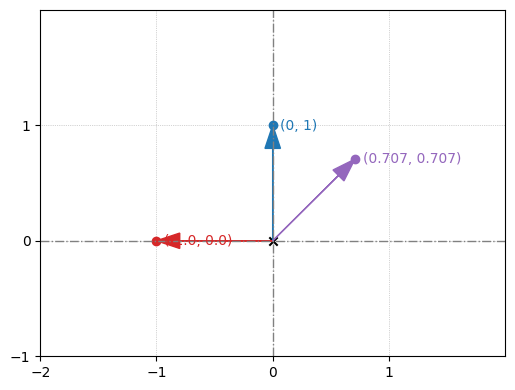

In [6]:
import math

from utils.transform import rotate2d
from utils.vector import as_vector2d
from utils.draw.component import Arrow2D, Color, Points2D, draw2d

# 定义二维坐标
v = as_vector2d((0, 1))

# 向左旋转 90°
v_new1 = rotate2d(math.pi / 2, v)
# 向右旋转 45°
v_new2 = rotate2d(-(math.pi / 4), v)

# 绘制图形
draw2d(
    [
        Points2D([v], color=Color.blue()),
        Arrow2D(v, color=Color.blue()),
        Points2D([v_new1], color=Color.red()),
        Arrow2D(v_new1, color=Color.red()),
        Points2D([v_new2], color=Color.purple()),
        Arrow2D(v_new2, color=Color.purple()),
    ],
    grid=(1, 1),
)

**知识:** 旋转三维向量

旋转二维向量的方法在三维空间也适用. 从某种意义上说, 所有的三维向量旋转在平面上都是孤立的. 例如, 试想三维点绕 $z$ 轴旋转, 其 $x$ 坐标和 $y$ 坐标会改变, 但 $z$ 坐标不变. 如果一个给定的点绕 $z$ 轴旋转, 无论旋转角度如何, 其 $z$ 坐标都不会改变, 该点保持在一个圆内

![X](../assets/rotate_by.jpg)


In [7]:
from utils.transform import rotate2d
from utils.vector import Vector3D


def rotate_z(angle: float, vector: Vector3D) -> Vector3D:
    """将三维向量围绕 `z` 轴进行旋转

    Args:
        `angle` (`float`): 旋转角度
        `vector` (`Vector3D`): 要选择的三维向量

    Returns:
        `Vector3D`: 旋转角度后的三维向量
    """
    # 获取三维分量
    x, y, z = vector

    # z 轴不变, 旋转 x, y 坐标
    new_x, new_y = rotate2d(angle, (x, y))

    # 返回旋转后的坐标
    return new_x, new_y, z

**练习:** 将三维向量 $(1, 0, 0)$ 围绕 $z$ 坐标轴旋转 $90\degree$ 以及 $-45\degree$


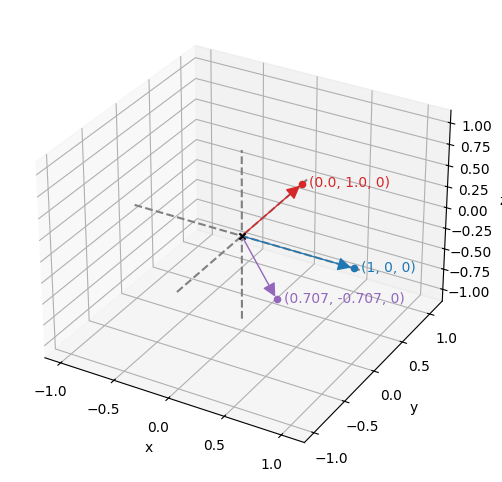

In [8]:
import math

from utils.transform import rotate_z
from utils.vector import as_vector3d
from utils.draw.component import Arrow3D, Color, Points3D, draw3d

# 定义三维变量
v = as_vector3d((1, 0, 0))

# 围绕 y 轴旋转向量
# 旋转 90°
v_new1 = rotate_z(math.pi / 2, v)
# 旋转 45°
v_new2 = rotate_z(-(math.pi / 4), v)

# 绘制图形
draw3d(
    [
        Points3D([v], color=Color.blue()),
        Arrow3D(v, color=Color.blue()),
        Points3D([v_new1], color=Color.red()),
        Arrow3D(v_new1, color=Color.red()),
        Points3D([v_new2], color=Color.purple()),
        Arrow3D(v_new2, color=Color.purple()),
    ]
)

**练习:** 绘制旋转 $45\degree$ 后的模型


In [9]:
%%capture

!python ./play/rotate_teapot_z.py

In [10]:
%%capture

!python ./play/rotate_teapot_x.py

### 1.4. 自定义几何变换

**知识:** 可以针对向量的某个轴的分量进行拉伸

In [11]:
from utils.typedef import Vector3D


def stretch(v: Vector3D, sx: float = 1.0, sy: float = 1.0, sz: float = 1.0) -> Vector3D:
    """拉伸一个向量

    Args:
        `v` (`Vector3D`): 要拉伸的三维向量
        `sx` (`float`, optional): `x` 轴拉伸倍数. Defaults to `1.0`.
        `sy` (`float`, optional): `y` 轴拉伸倍数. Defaults to `1.0`.
        `sz` (`float`, optional): `z` 轴拉伸倍数. Defaults to `1.0`.

    Returns:
        `Vector3D`: 拉伸后的向量
    """
    x, y, z = v
    return (x * sx, y * sy, z * sz)

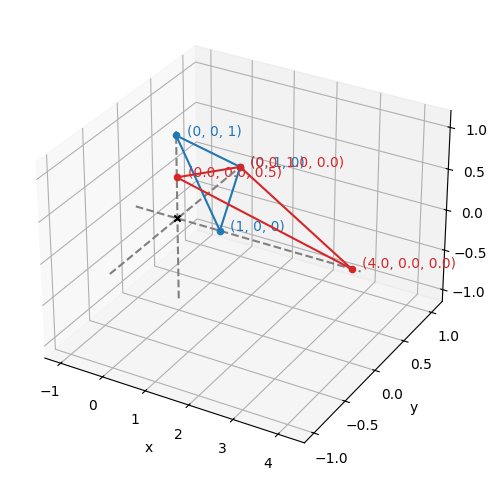

In [12]:
from utils.transform import stretch
from utils.vector import as_triangle
from utils.draw.component import Color, Points3D, Polygon3D, draw3d

face = as_triangle([(1, 0, 0), (0, 1, 0), (0, 0, 1)])
new_face = as_triangle(stretch(v, sx=4.0, sz=0.5) for v in face)

draw3d(
    [
        Points3D(face, color=Color.blue()),
        Polygon3D(face, color=Color.blue()),
        Points3D(new_face, color=Color.red()),
        Polygon3D(new_face, color=Color.red()),
    ]
)

**练习:** 将模型 x 轴方向拉伸 4 倍

In [13]:
%%capture

!python ./play/stretch_teapot_x.py

**练习:** 将模型 y 轴方向拉伸 4 倍

In [14]:
%%capture

!python ./play/stretch_teapot_y.py

**练习:** 将向量的指定维度拉伸其原始维度的三次方

因为拉伸的长度为指定向量维度的三次方, 所以对于向量长度大于 `1` 的, 相当于"拉伸"; 向量长度小于 `1` 的, 相当于"缩小"

In [15]:
from typing import Tuple

from utils.typedef import Number, Vector3D


def cube_stretch(
    v: Vector3D,
    dim: Tuple[Number, Number, Number] = (1, 1, 1),
) -> Vector3D:
    """三次方拉伸一个向量, 即拉伸向量指定维度的三次方

    Args:
        `v` (Vector3D): 要拉伸的三维向量
        `dim` (tuple, optional): 要拉伸的纬度. Defaults to `(1, 1, 1)`.

    Returns:
        Vector3D: _description_
    """
    return stretch(
        v,
        sx=v[0] ** 2 if dim[0] else 1.0,
        sy=v[1] ** 2 if dim[1] else 1.0,
        sz=v[2] ** 2 if dim[2] else 1.0,
    )

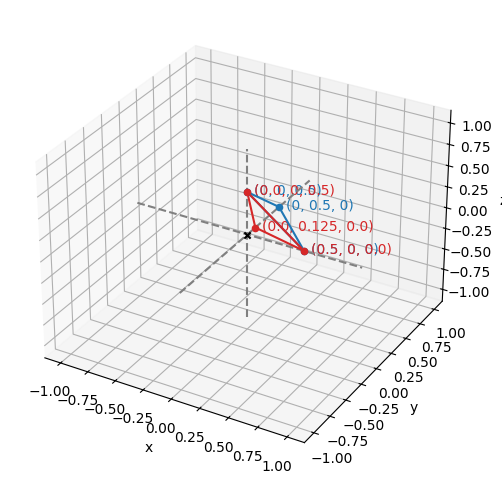

In [16]:
from utils.transform import cube_stretch
from utils.vector import as_triangle
from utils.draw.component import Color, Points3D, Polygon3D, draw3d

face = as_triangle([(0.5, 0, 0), (0, 0.5, 0), (0, 0, 0.5)])
new_face = as_triangle(cube_stretch(v, dim=(0, 1, 0)) for v in face)

draw3d(
    [
        Points3D(face, color=Color.blue()),
        Polygon3D(face, color=Color.blue()),
        Points3D(new_face, color=Color.red()),
        Polygon3D(new_face, color=Color.red()),
    ]
)

**练习:** 将茶壶的垂直尺寸按三次方拉伸

In [17]:
%%capture

!python ./play/cube_teapot.py

**练习:** 为现有的 $x$ 坐标加上 $y$ 坐标, 使茶壶向 $z$ 方向倾斜

In [18]:
%%capture

!python ./play/slant_teapot.py

**练习:** 令茶壶沿 $x$ 轴向下平移 `20` 个单位

将茶壶各个向量的 `z` 轴分量向负方向移动 `20` 个单位 (`add(v, (0, 0, -20))`), 呈现茶壶远离的效果

In [19]:
%%capture

!python ./play/translate_teapot_down_z.py

**练习:** 当按 `0` 和 `1` 之间的标量缩放每一个向量时, 茶壶会发生什么变化? 按系数 `-1` 缩放, 又会发生什么变化?

In [20]:
%%capture

# 向量乘以 0.5, 相当于缩小 1/2
!python ./play/scale_teapot_0.5.py

In [21]:
%%capture

# 向量乘以 -1, 相当于 x, y, z 轴全部翻转
!python ./play/scale_teapot_-1.py

**知识:** 向量的镜像操作. 注意: 对于一个多面体来说, 这种镜像不仅是"上下左右"进行了翻转, "里外"也进行了翻转

给向量乘以标量 `-1`, 即可将向量的三个坐标轴移动到相反的位置.

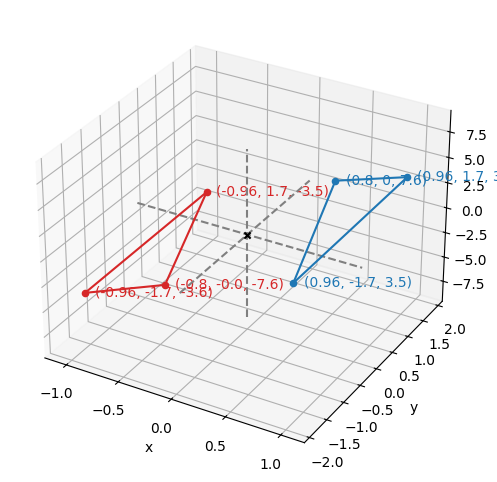

In [22]:
from utils.transform import scale
from utils.vector import as_triangle
from utils.draw.component import Color, Points3D, Polygon3D, draw3d

# 定义一组向量, 表示一个三角形
face = [
    (0.8, 0, 7.6),
    (0.96, 1.7, 3.6),
    (0.96, -1.7, 3.5),
]

# 计算 face 向量集合的镜像向量集合
face_new = as_triangle(scale(-1.0, f) for f in face)

# 绘制互为镜像的两个三角形
draw3d(
    [
        Points3D(face, color=Color.blue()),
        Polygon3D(face, color=Color.blue()),
        Points3D(face_new, color=Color.red()),
        Polygon3D(face_new, color=Color.red()),
    ]
)

**知识:** 向量转换操作的顺序问题

向量转换操作的顺序不同, 得到的结果也会不同. 例如对于"平移"和"缩放"两种操作的顺序, 先缩放后平移和先平移后缩放结果是不同的

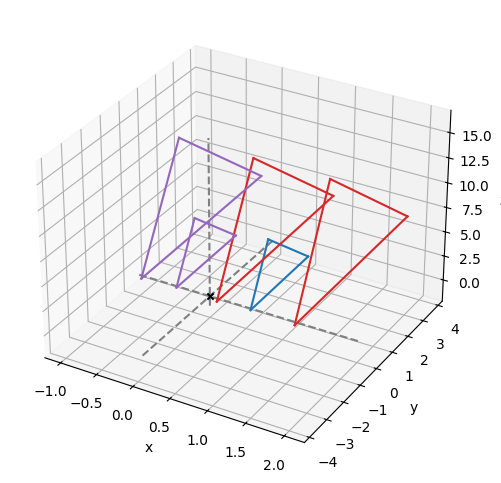

In [23]:
from utils.transform import scale
from utils.vector import add, as_triangle
from utils.draw.component import Color, Polygon3D, draw3d

# 定义一组向量, 表示一个三角形
face = as_triangle(
    [
        (0.8, 0, 7.6),
        (0.96, 1.7, 3.6),
        (0.96, -1.7, 3.5),
    ]
)

offset = (-1, 0, 0)

# 先放大 2 倍, 此时 x 坐标放大 2 倍, 相当于三角形整体向 x 正方向移动 x 坐标两倍的距离
face_scaled = as_triangle(scale(2.0, f) for f in face)
# 再在 x 坐标轴上平移 -1 个单位
face_scaled_translated = as_triangle(add(f, offset) for f in face_scaled)

# 先在 x 轴上平移 -1 个单位
face_translated = as_triangle(add(f, offset) for f in face)
# 在放大 2 倍, 由于 x 数值已经为负数, 所以三角形整体向 x 负方向移动 x 坐标两倍的距离
face_translated_scaled = as_triangle(scale(2.0, f) for f in face_translated)

# 绘制变化过程
draw3d(
    [
        Polygon3D(face, color=Color.blue()),
        Polygon3D(face_scaled, color=Color.red()),
        Polygon3D(face_scaled_translated, color=Color.red()),
        Polygon3D(face_translated, color=Color.purple()),
        Polygon3D(face_translated_scaled, color=Color.purple()),
    ]
)

**练习:** 比较先缩放后平移和先平移后缩放的结果不同

In [24]:
%%capture

# 先缩放然后平移
!python ./play/scale_translate_teapot.py

# 先平移然后缩放
!python ./play/translate_scale_teapot.py

**练习:** 把一个向量依次按系数 `1.5` 和 `0.4` 进行缩放, 得到的结果缩放系数为多少?

缩放系数为: $1 \times 1.5 \times 0.4 = 0.6$, 即最终结果是原始向量大小的 `60%`

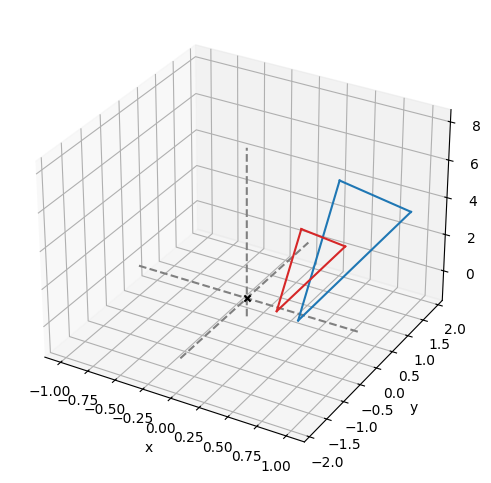

In [25]:
from utils.transform import scale
from utils.vector import as_triangle
from utils.draw.component import Color, Polygon3D, draw3d

# 定义向量
face = as_triangle(
    [
        (0.8, 0, 7.6),
        (0.96, 1.7, 3.6),
        (0.96, -1.7, 3.5),
    ]
)

# 执行放大 0.4 后放大 1.5 倍的操作
face_new = as_triangle(scale(0.4, scale(1.5, f)) for f in face)

# 绘制结果图形
draw3d(
    [
        Polygon3D(face, color=Color.blue()),
        Polygon3D(face_new, color=Color.red()),
    ]
)

**练习:** 定义 `compose(*fns)` 函数, 它将几个函数作为参数, 并返回一个新的函数, 即它们的组合

In [26]:
from typing import Callable

from utils.typedef import Vector3D


def compose(*fns: Callable[[Vector3D], Vector3D]) -> Callable[[Vector3D], Vector3D]:
    """将一系列向量处理组合在一起

    Returns:
        `Callable[[Vector3D], Vector3D]`: 返回组合处理函数
    """

    def fn(input: Vector3D) -> Vector3D:
        result = input

        # 依次执行处理函数
        for fn in reversed(fns):
            result = fn(result)

        return result

    return fn

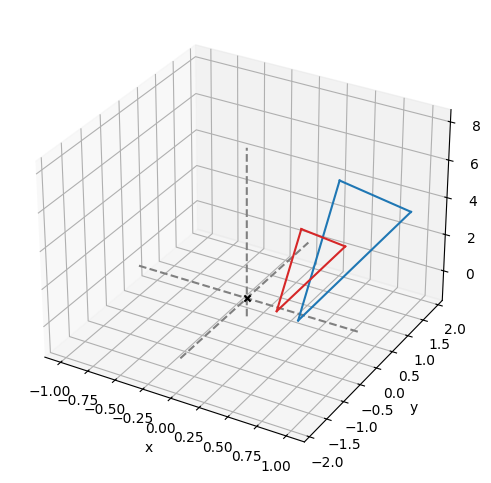

In [27]:
from functools import partial

from utils.transform import compose
from utils.vector import as_triangle, scale
from utils.draw.component import Color, Polygon3D, draw3d

# 定义一组变换函数的组合
fns = compose(
    partial(scale, 1.5),  # 缩放 1.5 倍
    partial(scale, 0.4),  # 缩放 0.4 倍
)

# 定义向量
face = as_triangle(
    [
        (0.8, 0, 7.6),
        (0.96, 1.7, 3.6),
        (0.96, -1.7, 3.5),
    ]
)

# 执行放大 0.4 后放大 1.5 倍的操作
face_new = as_triangle(fns(f) for f in face)

# 绘制结果图形
draw3d(
    [
        Polygon3D(face, color=Color.blue()),
        Polygon3D(face_new, color=Color.red()),
    ]
)

## 2. 线性变换

线性变换是一种良态 (Well-Behaved) 的向量变换. 除了向量, 线性变换也是线性代数的一个主要研究对象. 线性变换是一种向量运算在变换前后看起来一样的特殊变换. 下面通过一些图例来说明其含义

### 2.1. 向量运算的不变性

向量加法和标量乘法是向量算术运算中最重要的两个运算

把**两个向量的和**想象成将它们头尾相接放置时得出的新向量, 或者指向它们所张成平行四边形顶点的向量. 例如, 下图展示了向量和 $u + v = w$

![X](../assets/u+v=w.png)

如果对图中的三个向量应用同样的向量变换, 三个向量的关系是否会保持不变? 下面尝试一种关于原点做逆时针旋转的向量变换 $R$. 下图显示 $u$, $v$ 和 $w$ 通过变换 $R$ 旋转了相同的角度

![](../assets/uvw_rotate.png)

旋转后的图例表示向量 $R(u) + R(v) = R(w)$, 只要 $u + v = w$, 那么对三个向量 $u$, $v$ 和 $w$ 中的每个向量应用同样的旋转变换 $R$, $R(u) + R(v) = R(w)$ 依然成立. 这个特征可以描述为: **旋转保持 (Preserve) 了向量和**

同样, **旋转也会保持标量乘积**. 如果 $v$ 是一个向量, $sv$ 是 $v$ 乘以标量 $s$, 那么 $sv$ 指向与 $v$ 相同的方向, 只是被按照系数 $s$ 进行了缩放. 如果对 $v$ 和 $sv$ 做同样的旋转 $R$, $R(sv)$ 就是 $R(v)$ 与相同系数 $s$ 的标量乘积

对于任意向量 $u$, 标量 $s$ 和旋转 $R$, 图中都保持了相同的特性. 旋转或其他任意保持向量和与标量乘积的向量变换被称为**线性变换**

线性变换是**保持向量和与标量乘积的向量变换 $T$**. 也就是说, 对于任意输入向量 $u$ 和 $v$, 有:

$T(u) + T(v) = T(u + v)$

而对于任意一对标量 $s$ 和向量 $v$, 有:

$T(sv) = sT(v)$

### 2.2. 线性变换运算

**知识:** 向量长度的变化是线性变换

- 对于向量 $v$, 如果 $D(v) = n \cdot v$, 即 $D$ 为向量缩放操作, 则 $D$ 为线性变换
- 也就是说, $D$ 符合当 $u + v = w$ 时, $D(u) + D(v) = D(w)$, 即 $D(u) + D(v) = D(u + v)$
- 同样, 对于任意标量 $s$, 也有 $D(sv) = sD(v)$

In [28]:
from functools import partial

from utils.vector import add, scale

# 定义两个向量
u, v = (2.0, 3.0), (1.0, -1.0)

# 定义变换操作为缩放操作
fx = partial(scale, 2)

# 计算向量和 D(u) + D(v)
r = add(fx(u), fx(v))
print(f"D(u)+D(v)={r}")

# 计算 D(u + v), 其值应为 D(u) + D(v)
r = fx(add(u, v))
print(f"D(u+v)={r}")

# 计算 D(sv)
r = fx(scale(3, u))
print(f"D(sv)={r}")

# 计算 sD(v)
r = scale(3, fx(u))
print(f"sD(v)={r}")

D(u)+D(v)=(6.0, 4.0)
D(u+v)=(6.0, 4.0)
D(sv)=(12.0, 18.0)
sD(v)=(12.0, 18.0)


**知识:** 平移操作是非线性变换

- 对于向量 $v$, 如果 $B(v) = v + offset$, 即 $B$ 为向量平移操作, 则 $B$ 不是线性变换
- 也就是说, $B$ 无法令 $u + v = w$ 时, $B(u) + B(v) = B(w)$, 即 $B(u) + B(v) \ne B(u + v)$

事实证明, 只有不移动原点的变换才能是线性的 (例如长度缩放, 只是向量长度变化, 但向量的原点不变). 任何使用非零向量的平移都会将原点变换到不同的点上, 所以它不可能是线性的

In [29]:
from functools import partial

from utils.vector import add

# 定义两个向量
u, v = (2.0, 3.0), (1.0, -1.0)

# 定义变换操作为平移操作
fx = partial(add, (1, 0))

# 计算向量和 D(u) + D(v)
r = add(fx(u), fx(v))
print(f"D(u)+D(v)={r}")

# 计算 D(u + v), 其值不为 D(u) + D(v)
r = fx(add(u, v))
print(f"D(u+v) = {r}")

D(u)+D(v)=(5.0, 2.0)
D(u+v) = (4.0, 2.0)


### 2.3. 线性变换的作用

**知识:** 线性变换可以保持**线性组合**

一个向量集合的线性组合是它们的标量乘积之和. 例如, $3u - 2v$ 是向量 $u$ 和 $v$ 的线性组合; 而 $0.5u - v + 6w$ 是向量 $u$, $v$ 和 $w$ 的组合

**知识:** 保持向量线性组合的数学公式

如果有一个包含 `n` 个向量 ($v_1, v_2, \dots, v_n$) 的集合, 以及任意 `n` 个标量 ($s_1, s_2, \dots, s_n$), 则线性变换 $T$ 可以保持线性组合, 即:

$T(s_1v_1 + s_2v_2 + s_3v_3 + \dots + s_nv_n) = s_1T(v_1) + s_2T(v_2) + \dots + s_nT(v_n)$

**练习:** 如果对于向量 $v$, $T$ 为 $\frac12v$, 则计算向量 $u$, $v$ 的组合

T(u)+T(v)=(1.5, 1.0)


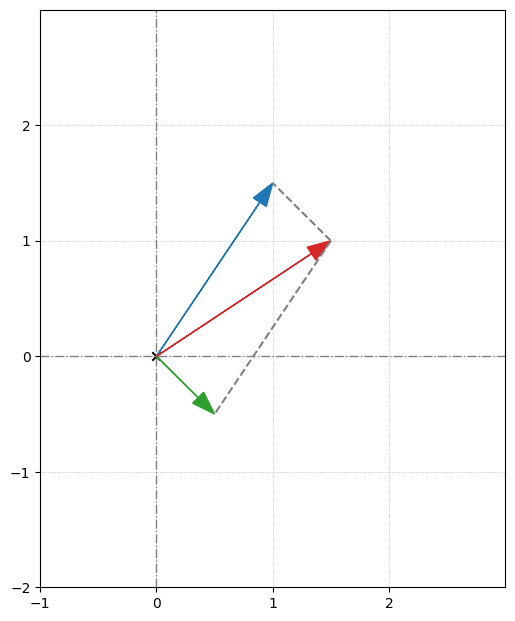

T(u+v)=(1.5, 1.0)


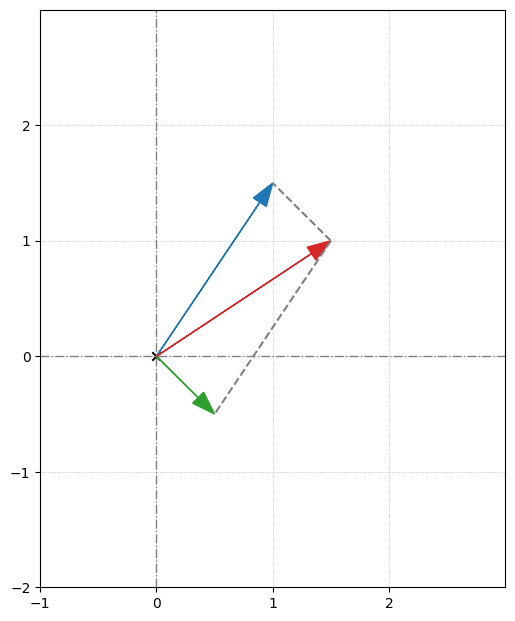

In [30]:
from functools import partial

from utils.vector import add, as_vector2d, scale
from utils.draw.component import Arrow2D, Color, LineStyle, Segment2D, draw2d

# 定义两个向量
u, v = (2.0, 3.0), (1.0, -1.0)

# 定义变换函数
fx = partial(scale, 1.0 / 2.0)

# 计算 T(u) + T(v)
r = as_vector2d(add(fx(u), fx(v)))
print(f"T(u)+T(v)={r}")

# 绘制结果
draw2d(
    [
        Arrow2D(as_vector2d(fx(u)), color=Color.blue()),  # 绘制 T(u)
        Arrow2D(as_vector2d(fx(v)), color=Color.green()),  # 绘制 T(v)
        Arrow2D(r, color=Color.red()),  # 绘制 T(u) + T(v)
        Segment2D(
            r, as_vector2d(fx(u)), color=Color.gray(), linestyle=LineStyle.dashed
        ),
        Segment2D(
            r, as_vector2d(fx(v)), color=Color.gray(), linestyle=LineStyle.dashed
        ),
    ]
)

# 计算 T(u + v), 其值应等于 T(u) + T(v)
r = as_vector2d(fx(add(u, v)))
print(f"T(u+v)={r}")

# 绘制结果
draw2d(
    [
        Arrow2D(as_vector2d(fx(u)), color=Color.blue()),  # 绘制 T(u)
        Arrow2D(as_vector2d(fx(v)), color=Color.green()),  # 绘制 T(v)
        Arrow2D(r, color=Color.red()),  # 绘制 T(u + v)
        Segment2D(
            r, as_vector2d(fx(u)), color=Color.gray(), linestyle=LineStyle.dashed
        ),
        Segment2D(
            r, as_vector2d(fx(v)), color=Color.gray(), linestyle=LineStyle.dashed
        ),
    ]
)

**知识**: 线性变换求两个向量的中点. 两个向量 $u$ 和 $v$ 坐标之间的中点可以用线性组合 $\frac12u + \frac12v = \frac12(u + v)$ 求得

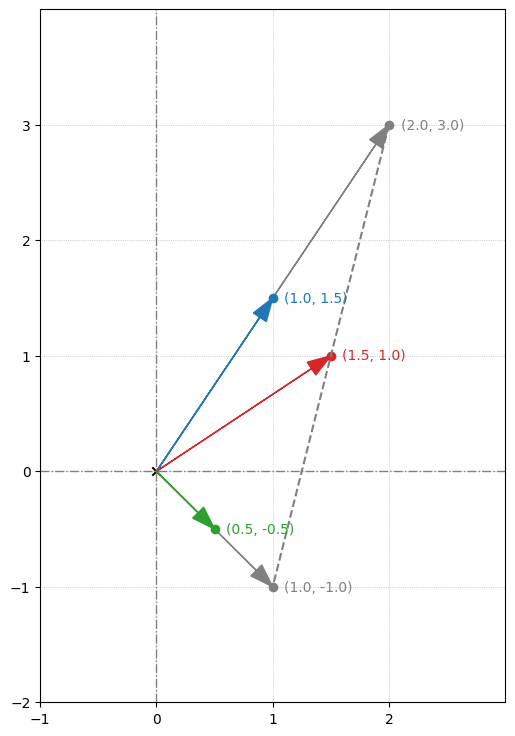

In [31]:
from functools import partial

from utils.vector import add, as_vector2d, scale
from utils.draw.component import Arrow2D, Color, LineStyle, Points2D, Segment2D, draw2d

# 定义两个向量
u, v = (2.0, 3.0), (1.0, -1.0)

# 定义变换函数
fx = partial(scale, 1.0 / 2.0)

draw2d(
    [
        Points2D([u], color=Color.gray()),  # 绘制原始 u 向量
        Arrow2D(u, color=Color.gray()),
        Points2D([v], color=Color.gray()),  # 绘制原始 v 向量
        Arrow2D(v, color=Color.gray()),
        Points2D([as_vector2d(fx(u))], color=Color.blue()),  # 绘制 T(u)
        Arrow2D(as_vector2d(fx(u)), color=Color.blue()),
        Points2D([as_vector2d(fx(v))], color=Color.green()),  # 绘制 T(v)
        Arrow2D(as_vector2d(fx(v)), color=Color.green()),
        # 绘制 T(u + v), 因为 T 为 (1/2)v, 所以 T(u + v) 为 T(u) 和 T(v) 连线的中点
        Arrow2D(as_vector2d(fx(add(u, v))), color=Color.red()),  # 绘制 T(u + v)
        Points2D([as_vector2d(fx(add(u, v)))], color=Color.red()),
        Segment2D(u, v, color=Color.gray(), linestyle=LineStyle.dashed),
    ]
)

**练习:** $u=(5, 3)$ 和 $v=(-2, 1)$ 之间的中点是什么? 把这三个点都画出来

根据公式可得中点向量坐标为: $\frac12 \cdot (u + v) = \frac12 \cdot u + \frac12 \cdot v$

center coord is: (1.5, 2.0)


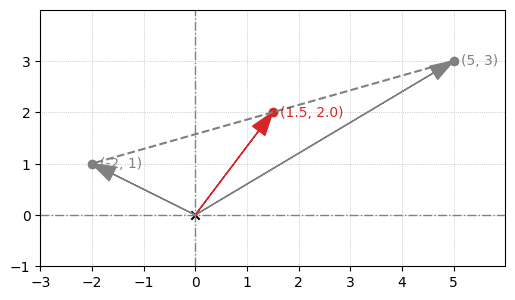

In [32]:
from functools import partial

from utils.vector import add, as_vector2d, scale
from utils.draw.component import Arrow2D, Color, LineStyle, Points2D, Segment2D, draw2d

# 定义二维向量
u, v = (5, 3), (-2, 1)

# 定义变换函数
fx = partial(scale, 1.0 / 2.0)

# 执行线性变换
r = as_vector2d(fx(add(u, v)))
print(f"center coord is: {r}")

# 绘制结果
draw2d(
    [
        Arrow2D(u, color=Color.gray()),
        Points2D([u], color=Color.gray()),
        Arrow2D(v, color=Color.gray()),
        Points2D([v], color=Color.gray()),
        Segment2D(u, v, color=Color.gray(), linestyle=LineStyle.dashed),
        Arrow2D(r, color=Color.red()),
        Points2D([r], color=Color.red()),
    ]
)

**练习:** 针对向量 $u$ 和 $v$, 绘图确认 $0.25 \cdot u + 0.75 \cdot v$ 在 $u$ 和 $v$ 连线的 `75%` 位置

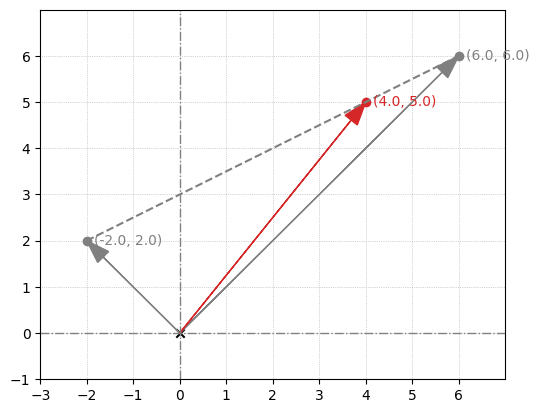

In [33]:
from utils.typedef import Vector2D
from utils.vector import add, as_vector2d, scale
from utils.draw.component import Arrow2D, Color, LineStyle, Points2D, Segment2D, draw2d

# 定义向量
u, v = (-2.0, 2.0), (6.0, 6.0)


def transform() -> Vector2D:
    """计算 0.25·u + 0.75·u 的结果"""
    return as_vector2d(
        add(scale(0.25, u), scale(0.75, v)),
    )


# 绘制向量计算结果
draw2d(
    [
        Arrow2D(u, color=Color.gray()),  # 绘制向量 u
        Points2D([u], color=Color.gray()),
        Arrow2D(v, color=Color.gray()),  # 绘制向量 v
        Points2D([v], color=Color.gray()),
        Segment2D(  # 绘制向量 u 和 v 的连线
            u,
            v,
            color=Color.gray(),
            linestyle=LineStyle.dashed,
        ),
        Arrow2D(transform(), color=Color.red()),  # 绘制向量 0.25u + 0.75v
        Points2D([transform()], color=Color.red()),
    ]
)

**知识:** **加权平均值**. 两个向量之间线段上的每个点都是形如 $su + (1 - s)v$ 的 **"加权平均值"**, 其中 $s$ 介于 `0` 和 `1` 之间

连接两个向量 $u$ 和 $v$ 的线段上的每一个点都是加权平均值, 因此也是点 $u$ 和 $v$ 的线性组合. 考虑到这一点, 可以思考线性变换对整个线段的作用

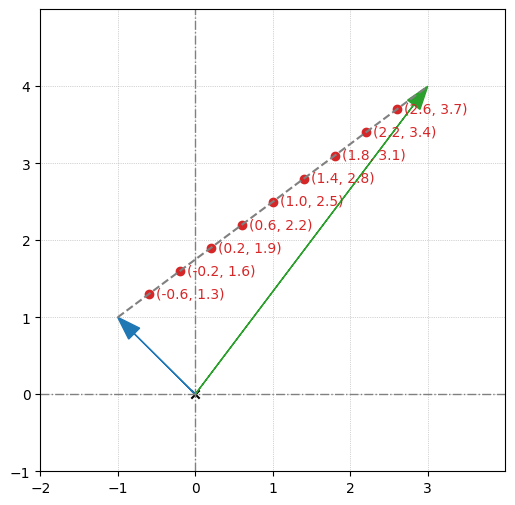

In [34]:
from utils.vector import add, as_vector2d, scale
from utils.draw.component import Arrow2D, Color, LineStyle, Points2D, Segment2D, draw2d

# 定义两个向量
u, v = (-1.0, 1.0), (3.0, 4.0)

# 通过加权平均值计算 uv 连线上的每个点
# s·u + (1-s)·v
points = [
    Points2D(
        # 绘制向量 s·u + (1-s)·v 的点
        [
            as_vector2d(
                add(
                    scale(s / 10.0, u),
                    scale(1.0 - s / 10.0, v),
                ),
            ),
        ],
        color=Color.red(),
    )
    for s in range(1, 10)
]

# 绘制结果
draw2d(
    [
        Arrow2D(u, color=Color.blue()),
        Arrow2D(v, color=Color.green()),
        Segment2D(u, v, color=Color.gray(), linestyle=LineStyle.dashed),
        *points,  # 绘制在 uv 连线上的 10 个点
    ]
)

**知识:** 加权平均值结合线性变换. 对于 $s$, 可以计算加权平均值为 $s \cdot u + (1 - s) \cdot v$. 对于线性变换 $T$, 则 $s \cdot T(u) + (1 - s) \cdot T(v) = T(s \cdot u + (1 -s) \cdot v)$

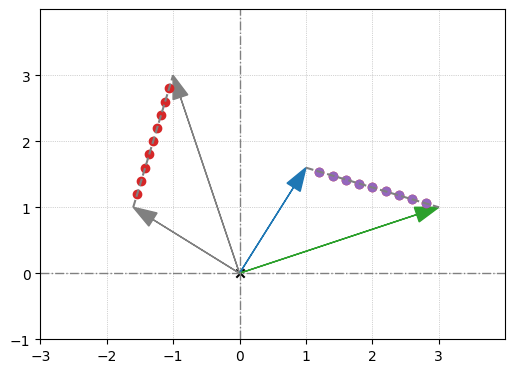

In [35]:
import math
from functools import partial

from utils.transform import rotate2d
from utils.typedef import Vector2D
from utils.vector import add, as_vector2d, scale
from utils.draw.component import Arrow2D, Color, LineStyle, Points2D, Segment2D, draw2d

# 定义两个向量
u, v = (-1.6, 1.0), (-1.0, 3.0)

fx = partial(rotate2d, 1.5 * math.pi)

# 通过加权平均值计算 uv 连线上的每个点, 即 s·u + (1-s)·v
points_1 = [
    Points2D(
        [
            as_vector2d(
                add(
                    scale(s / 10.0, u),
                    scale(1.0 - s / 10.0, v),
                )
            ),
        ],
        color=Color.red(),
        show_coord=False,
    )
    for s in range(1, 10)
]

# 对加权平均值进行线性变换, 即 s·T(u) + (1-s)·T(v)
points_2 = [
    Points2D(
        [
            as_vector2d(
                add(
                    scale(s / 10.0, fx(v=u)),
                    scale(1.0 - s / 10.0, fx(v=v)),
                )
            ),
        ],
        color=Color.red(),
        show_coord=False,
    )
    for s in range(1, 10)
]

# 对加权平均值进行线性变换, 即 T(s·u + (1-s)·v), 和 s·T(u) + (1-s)·T(v) 的点重合
points_3 = [
    Points2D(
        [
            fx(
                as_vector2d(
                    add(
                        scale(s / 10.0, u),
                        scale(1.0 - s / 10.0, v),
                    )
                )
            ),
        ],
        color=Color.purple(),
        show_coord=False,
    )
    for s in range(1, 10)
]

# 绘制结果
draw2d(
    [
        Arrow2D(u, color=Color.gray()),  # 绘制向量 u
        Arrow2D(v, color=Color.gray()),  # 绘制向量 v
        Segment2D(  # 绘制 uv 的连线
            u,
            v,
            color=Color.gray(),
            linestyle=LineStyle.dashed,
        ),
        Arrow2D(fx(v=u), color=Color.blue()),  # 绘制向量 T(u)
        Arrow2D(fx(v=v), color=Color.green()),  # 绘制向量 T(v)
        Segment2D(  # 绘制 T(u) 和 T(v) 的连线
            fx(v=u),
            fx(v=v),
            color=Color.gray(),
            linestyle=LineStyle.dashed,
        ),
        *points_1,  # s·u + (1-s)·v
        *points_2,  # s·T(u) + (1-s)·T(v)
        *points_3,  # T(s·u + (1-s)·v)
    ]
)

## 2.4. 计算线性变换

**知识:** 向量分解为线性组合

例如向量, $(4, 3, 5)$ 可以分解为 $(4, 0, 0) + (0, 3, 0) + (0, 0, 5)$. 这样就很容易想象出向量在三维空间中每一个维度上延伸的距离. 这可以进一步分解为线性组合

$(4, 3, 5) = 4 \cdot (1, 0, 0) + 3 \cdot (0, 1, 0) + 5 \cdot (0, 0, 1)$

(4*(1,0,0)+3*(0,1,0)+5*(0,0,1))=(4.0, 3.0, 5.0)


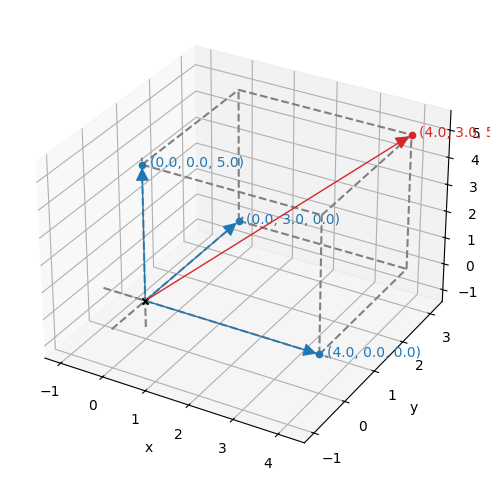

In [36]:
from utils.vector import add, as_vector3d, scale
from utils.draw.component import Arrow3D, Box3D, Color, Points3D, draw3d

# 定义原始三维向量
v = (4.0, 3.0, 5.0)

# 三维向量分解为 3 个向量组合
v1 = as_vector3d(scale(4.0, (1.0, 0.0, 0.0)))
v2 = as_vector3d(scale(3.0, (0.0, 1.0, 0.0)))
v3 = as_vector3d(scale(5.0, (0.0, 0.0, 1.0)))

# 计算向量组和, 得到原始向量
vs = as_vector3d(add(v1, v2, v3))
print(f"(4*(1,0,0)+3*(0,1,0)+5*(0,0,1))={vs}")

# 绘制原始向量和三个向量组和
draw3d(
    [
        Arrow3D(v, color=Color.red()),
        Points3D([v], color=Color.red()),
        Arrow3D(v1, color=Color.blue()),
        Points3D([v1], color=Color.blue()),
        Arrow3D(v2, color=Color.blue()),
        Points3D([v2], color=Color.blue()),
        Arrow3D(v3, color=Color.blue()),
        Points3D([v3], color=Color.blue()),
        Box3D(vs),
    ]
)

**知识:** 任何三维向量都可以被分解为 $(1, 0, 0)$, $(0, 1, 0)$ 和 $(0, 0, 1)$ 这三个向量的线性组合. 这种分解中出现的向量 $u$ 的标量正是 $v$ 的坐标

$(1, 0, 0)$, $(0, 1, 0)$ 和 $(0, 0, 1)$ 这三个向量被称为三维空间的标准基 (Standard Basis), 分别表示为 $e_1$, $e_2$ 和 $e_3$. 因此, 前面的线性组合可以写成 $(3, 4, 5) = 3e_1 + 4e_2 + 5e_3$

在二维空间中, $e_1=(1, 0)$, $e_2=(0, 1)$. 例如, $(7, -4) = 7e_1 - 4e_2$

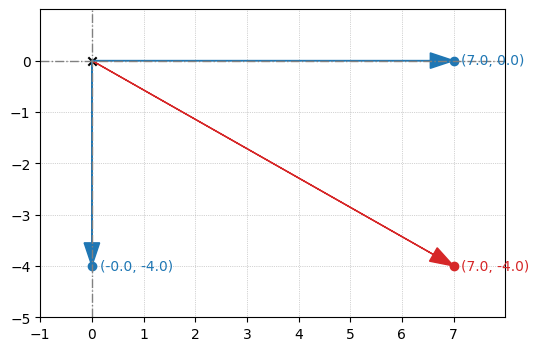

In [37]:
from utils.vector import as_vector2d, scale
from utils.draw.component import Arrow2D, Color, Points2D, draw2d

# 定义原始二维向量
v = (7.0, -4.0)

# 将原始二维向量分解为 2 个向量组合
v1 = as_vector2d(scale(7.0, (1.0, 0.0)))
v2 = as_vector2d(scale(-4.0, (0.0, 1.0)))

# 绘制原始向量和组合向量
draw2d(
    [
        Arrow2D(v, color=Color.red()),
        Points2D([v], color=Color.red()),
        Arrow2D(v1, color=Color.blue()),
        Points2D([v1], color=Color.blue()),
        Arrow2D(v2, color=Color.blue()),
        Points2D([v2], color=Color.blue()),
    ]
)

**知识:** 因为线性变换保持了线性组合, 所以在计算线性变换时只需知道它如何影响标准基向量即可

对于向量 $v = (m, n)$, 且 $e_1=(1, 0)$, $e_2=(0, 1)$, 向量 $v$ 即可分解为向量组合为 $v = m \cdot e_1 + n \cdot e_2$, 则:

$T(v) = T(m \cdot e_1 + n \cdot e_2) = m \cdot T(e_1) + n \cdot T(e_2)$

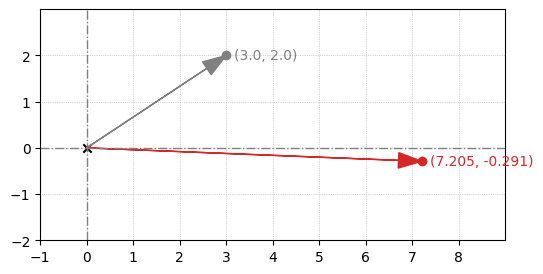

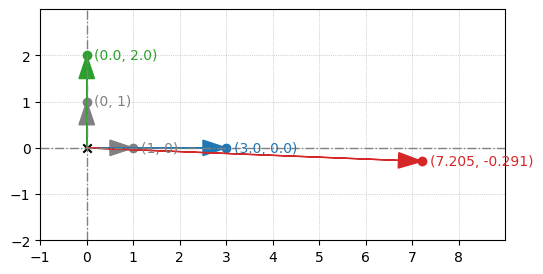

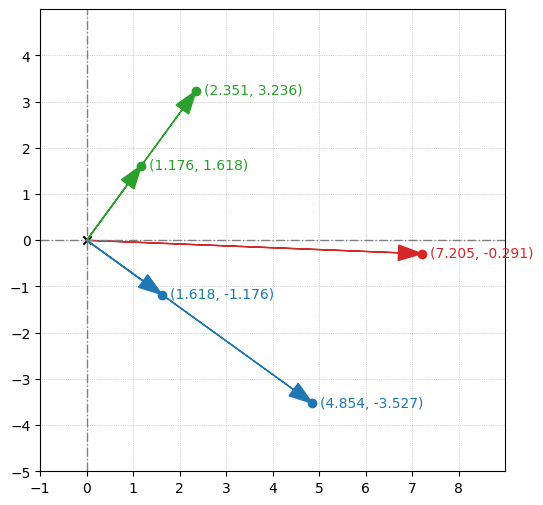

In [38]:
import math

from utils.transform import add, rotate2d, scale
from utils.vector import Vector2D, as_vector2d
from utils.draw.component import Arrow2D, Color, Points2D, draw2d


def fx(v: Vector2D) -> Vector2D:
    """定义线性变换函数

    Args:
        `v` (`Vector2D`): 要变换的向量

    Returns:
        `Vector2D`: 变换结果
    """
    # 向量放大
    v = as_vector2d(scale(2, v))
    # 向量旋转
    return rotate2d(-(math.pi / 5), v)


# 原始二维变量
v = as_vector2d((3.0, 2.0))
# 计算 T(v)
fx_v = fx(v)

# 绘制原始二位变量和变换后的二维变量
draw2d(
    [
        Arrow2D(v, color=Color.gray()),
        Points2D([v], color=Color.gray()),
        Arrow2D(fx_v, color=Color.red()),
        Points2D([fx_v], color=Color.red()),
    ]
)

# 定义二维变量的标准基
e1, e2 = as_vector2d((1, 0)), as_vector2d((0, 1))
# 定义 3*e1 和 2*e2, 即原始向量的 2 个向量组合
se1, se2 = as_vector2d(scale(3.0, e1)), as_vector2d(scale(2.0, e2))
# 计算 T(3*e1 + 2*e2), 其中 3*e1 + 2*e2 = v
fx_e = fx(as_vector2d(add(se1, se2)))

# 绘图以证明 T(3*e1 + 2*e2) = T(v)
draw2d(
    [
        Arrow2D(e1, color=Color.gray()),
        Points2D([e1], color=Color.gray()),
        Arrow2D(e2, color=Color.gray()),
        Points2D([e2], color=Color.gray()),
        Arrow2D(se1, color=Color.blue()),
        Points2D([se1], color=Color.blue()),
        Arrow2D(se2, color=Color.green()),
        Points2D([se2], color=Color.green()),
        Arrow2D(fx_e, color=Color.red()),
        Points2D([fx_e], color=Color.red()),
    ]
)

# 定义 T(e1) 和 T(e2)
fx_e1, fx_e2 = as_vector2d(fx(e1)), as_vector2d(fx(e2))
# 定义 3*T(e1) 和 2*T(e2)
sfx_e1, sfx_e2 = as_vector2d(scale(3.0, fx_e1)), as_vector2d(scale(2.0, fx_e2))
# 计算 3*T(e1) + 2*T(e2)
sfx_add = as_vector2d(add(sfx_e1, sfx_e2))

# 绘图以证明 3*T(e1) + 2*T(e2) = T(3*e1 + 2*e2) = T(v)
draw2d(
    [
        Arrow2D(fx_e1, color=Color.blue()),
        Points2D([fx_e1], color=Color.blue()),
        Arrow2D(fx_e2, color=Color.green()),
        Points2D([fx_e2], color=Color.green()),
        Arrow2D(sfx_e1, color=Color.blue()),
        Points2D([sfx_e1], color=Color.blue()),
        Arrow2D(sfx_e2, color=Color.green()),
        Points2D([sfx_e2], color=Color.green()),
        Arrow2D(sfx_add, color=Color.red()),
        Points2D([sfx_add], color=Color.red()),
    ]
)

**练习:** 已知标准基向量为 $e_1 = (1, 0, 0), e_2 = (0, 1, 0), e_3 = (0, 0, 1)$, 且线性变换为 $T$

若 $T$ 应用于标准基向量的接过已知, 为: $T(e_1) = (1, 1, 1), T(e_2) = (1, 0, -1), T(e_3) = (0, 1, 1)$, 则为茶壶模型的每个向量 $v$ 执行线性变换

解: 对于任意向量 $v=(x, y, z)$, 由 $v = e_1 \cdot x + e_2 \cdot y + e_3 \cdot z$ 可得

$T(v) = T(e_1 \cdot x) + T(e_2 \cdot y) + T(e_3 \cdot z) = x \cdot T(e_1) + y \cdot T(e_2) + z \cdot T(e_3) $

In [39]:
%%capture

!python ./play/linear_transform_teapot.py